In [ ]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
train_data=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
test_data=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

train_loader=torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True,num_workers=2)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=32,shuffle=False,num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


In [ ]:
image,label=train_data[0]

In [ ]:
image.size()

torch.Size([3, 32, 32])

In [ ]:
class_names=['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
class CifarNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)   #3 input channel,feature maps=128,3 kernel size (news shape=(input size+2p-kernel size)/stides of kernel+1=31/1=31=32)
        #new shape will be(32,32,32)
        self.bn1 = nn.BatchNorm2d(128)                             # batchNorm after conv1
        self.pool = nn.MaxPool2d(2, 2)                           #new shape will be(32,16,16)

        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1) #new shape=16+2p-3/1 +1 =16 shape will be(64,16,16)
        self.bn2 = nn.BatchNorm2d(64)
        # pooling after conv2 -> (64,8,8)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) #new shape=8+2p-3/1 +1 =8 shape will be(128,8,8)
        self.bn3 = nn.BatchNorm2d(128)
        # no pooling here to retain dimensions

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # #new shape=8+2p-3/1 +1 =8 shape will be(256,8,8)
        self.bn4 = nn.BatchNorm2d(256)
        # pooling after conv4 -> (256,4,4)

        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.bn5 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn6 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64)
        self.bn7 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))       # (32,16,16)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))       # (64,8,8)
        x = F.relu(self.bn3(self.conv3(x)))                  # (128,8,8) # no pooling here to retain dimensions
        x = self.pool(F.relu(self.bn4(self.conv4(x))))       # (256,4,4)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = F.relu(self.bn7(self.fc3(x)))
        x = self.fc4(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
net = CifarNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=1e-4)

In [ ]:
for epoch in range(200):
    print(f'Training epoch {epoch}..')

    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'loss: {running_loss/len(train_loader):.4f}')

Training epoch 0..
loss: 1.2471
Training epoch 1..
loss: 0.8821
Training epoch 2..
loss: 0.7444
Training epoch 3..
loss: 0.6628
Training epoch 4..
loss: 0.5960
Training epoch 5..
loss: 0.5428
Training epoch 6..
loss: 0.4965
Training epoch 7..
loss: 0.4572
Training epoch 8..
loss: 0.4222
Training epoch 9..
loss: 0.3996
Training epoch 10..
loss: 0.3713
Training epoch 11..
loss: 0.3450
Training epoch 12..
loss: 0.3309
Training epoch 13..
loss: 0.3061
Training epoch 14..
loss: 0.2995
Training epoch 15..
loss: 0.2796
Training epoch 16..
loss: 0.2766
Training epoch 17..
loss: 0.2635
Training epoch 18..
loss: 0.2555
Training epoch 19..
loss: 0.2446
Training epoch 20..
loss: 0.2442
Training epoch 21..
loss: 0.2346
Training epoch 22..
loss: 0.2278
Training epoch 23..
loss: 0.2252
Training epoch 24..
loss: 0.2226
Training epoch 25..
loss: 0.2153
Training epoch 26..
loss: 0.2135
Training epoch 27..
loss: 0.2057
Training epoch 28..
loss: 0.2132
Training epoch 29..
loss: 0.2035
Training epoch 30..


In [ ]:
torch.save(net.state_dict(),'cifar_net.pth')

In [ ]:
net=CifarNN()
net.load_state_dict(torch.load('cifar_net.pth'))

<All keys matched successfully>

In [ ]:
correct=0
total=0

net.eval()

with torch.no_grad():
  for data in test_loader:
    images,labels=data
    outputs=net(images)
    _,predicted=torch.max(outputs,1)
    total += labels.size(0)
    correct +=(predicted==labels).sum().item()

accuracy=100*correct/total

print(f'Accuracy: {accuracy}%')

Accuracy: 82.25%


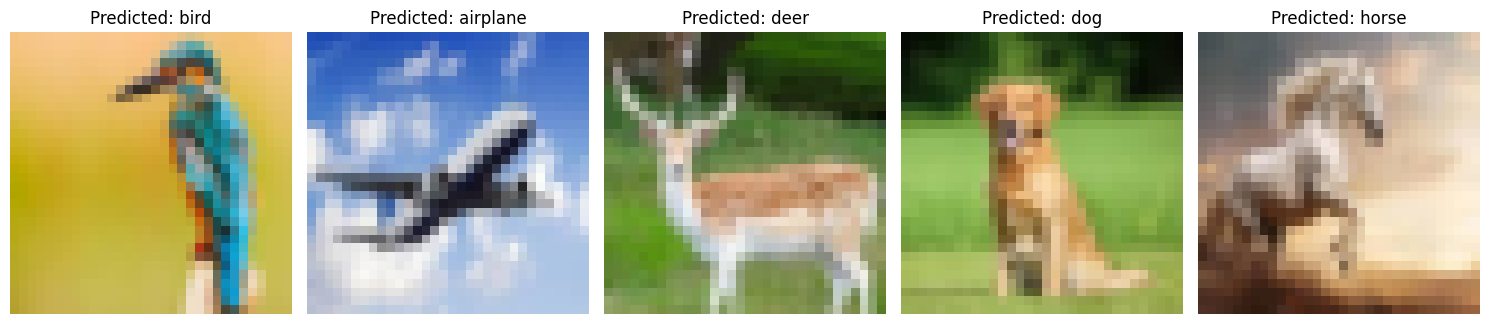

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# Transformations
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

denormalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)

# CIFAR-10 class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Image loading function
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transformed = new_transform(image)
    image = torch.unsqueeze(transformed, 0)  # Add batch dimension
    return image, transformed

# Image paths
image_paths = ['bird.jpg', 'plane.jpg', 'deer.jpg', 'dog.jpg', 'horse.jpg']
images = [load_image(img) for img in image_paths]

# Inference
net.eval()
net.to(device)

fig, axes = plt.subplots(1, len(images), figsize=(15, 4))  # 1 row, N columns

with torch.no_grad():
    for idx, (orig_image, tensor_image) in enumerate(images):
        output = net(orig_image.to(device))
        _, predicted = torch.max(output, 1)
        label = class_names[predicted.item()]

        # Denormalize for visualization
        img_np = denormalize(tensor_image).permute(1, 2, 0).cpu().numpy()
        img_np = img_np.clip(0, 1)  # Ensure values are within [0,1]

        # Show image in horizontal subplot
        axes[idx].imshow(img_np)
        axes[idx].set_title(f'Predicted: {label}')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
net = CifarNN().to(device)
net.load_state_dict(torch.load('cifar_net.pth', map_location=device))
net.eval()

CifarNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_fe

In [ ]:
dog_images = []
dog_labels = []

for img, label in test_data:
    if label == 5:  # dog
        dog_images.append(img.unsqueeze(0))
        dog_labels.append(label)

dog_images = torch.cat(dog_images).to(device)         # [N_dogs, 3, 32, 32]
dog_labels = torch.tensor(dog_labels, device=device)  # [N_dogs]
print("Total dog images:", dog_labels.numel())


Total dog images: 1000


In [ ]:
criterion = nn.CrossEntropyLoss()

def targeted_fgsm(model, images, target_labels, epsilon):
    images = images.clone().detach().to(device)
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, target_labels)
    model.zero_grad()
    loss.backward()
    adv_images = images - epsilon * images.grad.sign()  # subtract for targeted
    adv_images = torch.clamp(adv_images, -1, 1).detach()
    return adv_images

def targeted_pgd(model, images, target_labels, epsilon, alpha, steps):
    ori_images = images.clone().detach().to(device)
    adv_images = ori_images.clone().detach()
    for _ in range(steps):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = criterion(outputs, target_labels)
        model.zero_grad()
        loss.backward()
        adv_images = adv_images - alpha * adv_images.grad.sign()
        # Project into L-inf epsilon-ball around original & keep valid range
        perturb = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(ori_images + perturb, -1, 1).detach()
    return adv_images


In [ ]:
# Target: bird (index 2), Source: dog (index 5)
epsilon = 0.03   # max L-inf budget
alpha   = 0.007  # PGD step size
steps   = 40     # PGD steps

target_labels = torch.full_like(dog_labels, 2)  # all birds

# Generate
adv_fgsm = targeted_fgsm(net, dog_images, target_labels, epsilon)
adv_pgd  = targeted_pgd(net, dog_images, target_labels, epsilon, alpha, steps)


In [ ]:
TOTAL_DOGS = dog_labels.numel()

# Baseline (no attack)
with torch.no_grad():
    preds_before = net(dog_images).argmax(1)
baseline_correct_dog = (preds_before == 5).sum().item()
baseline_acc = 100.0 * baseline_correct_dog / TOTAL_DOGS

# FGSM
with torch.no_grad():
    preds_fgsm = net(adv_fgsm).argmax(1)
fgsm_to_bird = (preds_fgsm == 2).sum().item()
fgsm_target_success = 100.0 * fgsm_to_bird / TOTAL_DOGS
fgsm_true_dog_acc = 100.0 * (preds_fgsm == 5).sum().item() / TOTAL_DOGS

# PGD
with torch.no_grad():
    preds_pgd = net(adv_pgd).argmax(1)
pgd_to_bird = (preds_pgd == 2).sum().item()
pgd_target_success = 100.0 * pgd_to_bird / TOTAL_DOGS
pgd_true_dog_acc = 100.0 * (preds_pgd == 5).sum().item() / TOTAL_DOGS

print(f"Total dog images: {TOTAL_DOGS}")
print(f"Baseline accuracy on dogs (pred==dog): {baseline_correct_dog}/{TOTAL_DOGS} ({baseline_acc:.2f}%)")
print(f"FGSM targeted success (pred==bird): {fgsm_to_bird}/{TOTAL_DOGS} ({fgsm_target_success:.2f}%)")
print(f"FGSM accuracy vs true dog after attack (pred==dog): {fgsm_true_dog_acc:.2f}%")
print(f"PGD targeted success (pred==bird): {pgd_to_bird}/{TOTAL_DOGS} ({pgd_target_success:.2f}%)")
print(f"PGD accuracy vs true dog after attack (pred==dog): {pgd_true_dog_acc:.2f}%")



Total dog images: 1000
Baseline accuracy on dogs (pred==dog): 726/1000 (72.60%)
FGSM targeted success (pred==bird): 782/1000 (78.20%)
FGSM accuracy vs true dog after attack (pred==dog): 6.80%
PGD targeted success (pred==bird): 1000/1000 (100.00%)
PGD accuracy vs true dog after attack (pred==dog): 0.00%


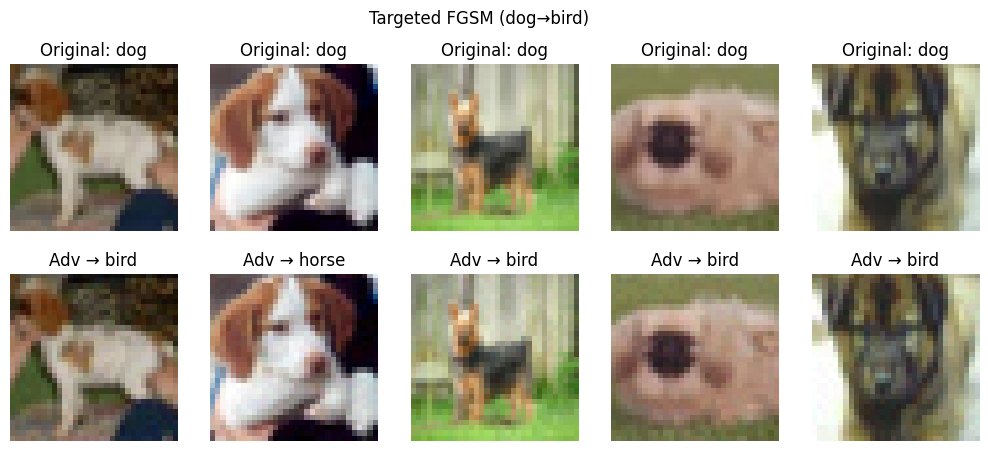

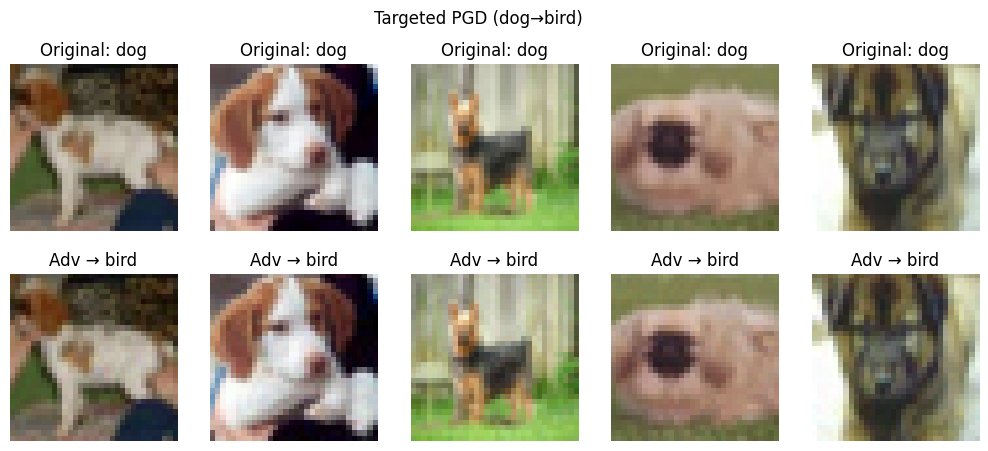

In [ ]:
def show_images(orig, adv, preds, title, k=5):
    k = min(k, orig.size(0))
    fig, axes = plt.subplots(2, k, figsize=(2.5*k, 5))
    for i in range(k):
        # de-normalize: x' = x*0.5 + 0.5
        axes[0, i].imshow((orig[i].detach().cpu().permute(1,2,0)*0.5 + 0.5).clamp(0,1))
        axes[0, i].set_title("Original: dog")
        axes[0, i].axis('off')

        axes[1, i].imshow((adv[i].detach().cpu().permute(1,2,0)*0.5 + 0.5).clamp(0,1))
        axes[1, i].set_title(f"Adv → {class_names[preds[i].item()]}")
        axes[1, i].axis('off')
    plt.suptitle(title)
    plt.show()

show_images(dog_images, adv_fgsm, preds_fgsm, "Targeted FGSM (dog→bird)", k=5)
show_images(dog_images, adv_pgd,  preds_pgd,  "Targeted PGD (dog→bird)",  k=5)
